In [454]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import metrics
from numpy import mean
from numpy import std
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
# import geneticalgorithmrf  #genetic algorithum module
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from numpy.random import seed
import time

In [455]:
df = pd.read_csv('Kepler.csv', skiprows = 144, index_col = False)

df = df.drop(['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_vet_stat', 'koi_vet_date',
             'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
             'koi_fpflag_ec', 'koi_disp_prov', 'koi_comment', 'koi_srho', 'koi_srho_err1', 'koi_srho_err2', 'koi_fittype',
             'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_time0', 'koi_time0_err1', 'koi_time0_err2',
             'koi_limbdark_mod', 'koi_ldm_coeff4', 'koi_ldm_coeff3', 'koi_ldm_coeff2', 'koi_ldm_coeff1',
             'koi_parm_prov', 'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_count', 'koi_num_transits',
             'koi_tce_plnt_num', 'koi_quarters', 'koi_bin_oedp_sig',
             'koi_trans_mod', 'koi_model_dof', 'koi_model_chisq', 'koi_datalink_dvr',
             'koi_datalink_dvs', 'koi_sparprov', 'ra', 'dec', 'koi_kepmag', 'koi_gmag',
             'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag', 'koi_kmag',
             'koi_fwm_stat_sig', 'koi_fwm_sra', 'koi_fwm_sra_err', 'koi_fwm_sdec',
             'koi_fwm_sdec_err', 'koi_fwm_srao', 'koi_fwm_srao_err', 'koi_fwm_sdeco',
             'koi_fwm_sdeco_err', 'koi_fwm_prao', 'koi_fwm_prao_err', 'koi_fwm_pdeco',
             'koi_fwm_pdeco_err', 'koi_dicco_mra', 'koi_dicco_mra_err', 'koi_dicco_mdec',
             'koi_dicco_mdec_err', 'koi_dicco_msky', 'koi_dicco_msky_err',
             'koi_dikco_mra', 'koi_dikco_mra_err', 'koi_dikco_mdec', 'koi_dikco_mdec_err',
             'koi_dikco_msky', 'koi_dikco_msky_err', 'koi_eccen_err1',
             'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_ingress',
             'koi_ingress_err1', 'koi_ingress_err2', 'koi_sma_err1', 'koi_sma_err2',
             'koi_incl_err1', 'koi_incl_err2', 'koi_sage', 'koi_sage_err1', 'koi_sage_err2', 'koi_eccen'], axis = 1)

# Limit target values to CANDIDATE and CONFIRMED
false_positive_rows = df.query("koi_disposition == 'FALSE POSITIVE'").index
df = df.drop(false_positive_rows, axis=0).reset_index(drop=True)

#Transforming target column in binary data
df['koi_disposition'] = df['koi_disposition'].map({"CANDIDATE":1,"CONFIRMED":0})

df['koi_tce_delivname'] = df['koi_tce_delivname'].fillna(df['koi_tce_delivname'].mode()[0])
for column in df.columns[df.isna().sum() > 0]:
    df[column] = df[column].fillna(df[column].mean())

delivname_dummies = pd.get_dummies(df['koi_tce_delivname'], prefix='delivname')
df = pd.concat([df, delivname_dummies], axis=1)
df = df.drop(['koi_tce_delivname', 'delivname_q1_q16_tce', 'delivname_q1_q17_dr24_tce',
       'delivname_q1_q17_dr25_tce'], axis=1)

y = df['koi_disposition']
df = df.drop('koi_disposition', axis = 1)

In [456]:
df

,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,...,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2
0,9.488036,0.000028,-0.000028,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.9575,...,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046
1,54.418383,0.000248,-0.000248,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.5070,...,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046
2,19.899140,0.000015,-0.000015,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.7822,...,-0.176,-0.18,0.30,-0.30,0.868,0.233,-0.078,0.961,0.110,-0.121
3,2.525592,0.000004,-0.000004,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.6545,...,-0.210,0.07,0.25,-0.30,1.046,0.334,-0.133,1.095,0.151,-0.136
4,11.094321,0.000020,-0.000020,171.201160,0.001410,-0.001410,0.538,0.030,-0.428,4.5945,...,-0.229,-0.08,0.25,-0.30,0.972,0.315,-0.105,1.053,0.135,-0.150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4720,7.268182,0.000164,-0.000164,135.934800,0.023500,-0.023500,0.780,0.200,-0.555,4.9850,...,-0.135,0.00,0.25,-0.30,2.219,0.536,-0.996,1.398,0.212,-0.318
4721,376.379890,0.046800,-0.046800,486.602200,0.071100,-0.071100,0.305,0.208,-0.305,13.9900,...,-0.216,-0.32,0.30,-0.30,0.955,0.291,-0.097,1.025,0.134,-0.134
4722,367.947848,0.004790,-0.004790,416.209980,0.009720,-0.009720,0.902,0.062,-0.638,4.2490,...,-0.170,0.07,0.25,-0.30,0.855,0.207,-0.069,0.971,0.075,-0.113
4723,1.739849,0.000018,-0.000018,133.001270,0.007690,-0.007690,0.043,0.423,-0.043,3.1140,...,-0.224,-0.04,0.25,-0.30,1.031,0.341,-0.114,1.075,0.151,-0.135


In [457]:
for column in df.columns[df.isna().sum() > 0]:
    df[column] = df[column].fillna(df[column].mean())

In [458]:
['Period', 'Period_err1', 'Period_err2', 'Time', 'Time_err1', 'Time_err2', 'Impact', 'Impact_err1', 'Impact_err2',
'Duration', 'Duration_err1', 'Duration_err2', 'Depth', 'Depth_err1', 'Depth_err2', 'Rho',
 'Rho_err1', 'Rho_err2', 'Rp', 'Rp_err1', 'Rp_err2', 'Semi-major axis', 'Inclination', 'Insolation', 'Insolation_err1', 'Insolation_err2',
 'd/Rs', 'd/Rs_err1', 'd/Rs_err2', 'SNR', 'Ts', 'Ts_err1', 'Ts_err2', 'log(g)', 'log(g)_err1', 'log(g)_err2', 'Zs', 'Zs_err1', 'Zs_err2',
 'Rs', 'Rs_err1', 'Rs_err2', 'Ms', 'Ms_err1', 'Ms_err2']

['Period',
 'Period_err1',
 'Period_err2',
 'Time',
 'Time_err1',
 'Time_err2',
 'Impact',
 'Impact_err1',
 'Impact_err2',
 'Duration',
 'Duration_err1',
 'Duration_err2',
 'Depth',
 'Depth_err1',
 'Depth_err2',
 'Rho',
 'Rho_err1',
 'Rho_err2',
 'Rp',
 'Rp_err1',
 'Rp_err2',
 'Semi-major axis',
 'Inclination',
 'Insolation',
 'Insolation_err1',
 'Insolation_err2',
 'd/Rs',
 'd/Rs_err1',
 'd/Rs_err2',
 'SNR',
 'Ts',
 'Ts_err1',
 'Ts_err2',
 'log(g)',
 'log(g)_err1',
 'log(g)_err2',
 'Zs',
 'Zs_err1',
 'Zs_err2',
 'Rs',
 'Rs_err1',
 'Rs_err2',
 'Ms',
 'Ms_err1',
 'Ms_err2']

In [459]:
kf = pd.read_csv('K2.csv', skiprows = 298, index_col = False)
false_positive_rows = kf.query("disposition == 'FALSE POSITIVE'").index
kf = kf.drop(false_positive_rows, axis=0).reset_index(drop=True)

#Transforming target column in binary data
kf['disposition'] = kf['disposition'].map({"CANDIDATE":1,"CONFIRMED":0})


y = pd.concat([y, kf['disposition']], axis = 0)

In [460]:
tf = pd.read_csv('TESS.csv', skiprows = 90, index_col = False)
false_positive_rows = tf.query("tfopwg_disp == 'FA' or tfopwg_disp == 'FP' or tfopwg_disp == 'APC'").index
tf = tf.drop(false_positive_rows, axis=0).reset_index(drop=True)

#Transforming target column in binary data
tf['tfopwg_disp'] = tf['tfopwg_disp'].map({"PC":1,"CP":0, "KP":0})


y = pd.concat([y, tf['tfopwg_disp']], axis = 0)

In [461]:
nanys = np.where(np.isnan(y))[0]
y = y.values
y = np.delete(y, nanys)

In [462]:

inter = ['pl_orbper','pl_orbpererr1', 'pl_orbpererr2', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_imppar', 'pl_impparerr1', 'pl_impparerr2',
        'pl_trandur', 'pl_trandurerr1', 'pl_trandurerr2', 'trandep', 'trandeperr1', 'trandeperr2', 'pl_ratror', 'pl_ratrorerr1', 'pl_ratrorerr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2',
        'pl_orbsmax', 'pl_orbincl', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_ratdor', 'pl_ratdorerr1', 'pl_ratdorerr2', 'SNR',
        'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_logg', 'st_loggerr1', 'st_loggerr2', 'st_met', 'st_meterr1', 'st_meterr2', 'st_rad', 'st_raderr1',
        'st_raderr2', 'st_mass', 'st_masserr1', 'st_masserr2']
finarr = []
for column in inter:
    if column in kf.columns:
        if column == 'pl_tranmid':
            colly = kf[column] - 2454833.0
            finarr.append(colly)
        elif column == 'trandep' or column == 'trandeperr1' or column == 'trandeperr2':
            colly = kf[column] * 10000
            finarr.append(colly)
        else:
            colly = kf[column]
            finarr.append(colly)
    else:
        finarr.append([np.nan]*len(kf['rowid']))
kf = pd.DataFrame(np.array(finarr), index = ['pl_orbper','pl_orbpererr1', 'pl_orbpererr2', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_imppar', 'pl_impparerr1', 'pl_impparerr2',
        'pl_trandur', 'pl_trandurerr1', 'pl_trandurerr2', 'trandep', 'trandeperr1', 'trandeperr2', 'pl_ratror', 'pl_ratrorerr1', 'pl_ratrorerr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2',
        'pl_orbsmax', 'pl_orbincl', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_ratdor', 'pl_ratdorerr1', 'pl_ratdorerr2', 'SNR',
        'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_logg', 'st_loggerr1', 'st_loggerr2', 'st_met', 'st_meterr1', 'st_meterr2', 'st_rad', 'st_raderr1',
        'st_raderr2', 'st_mass', 'st_masserr1', 'st_masserr2']).T
kf.columns = ['Period', 'Period_err1', 'Period_err2', 'Time', 'Time_err1', 'Time_err2', 'Impact', 'Impact_err1', 'Impact_err2',
'Duration', 'Duration_err1', 'Duration_err2', 'Depth', 'Depth_err1', 'Depth_err2', 'Rho',
 'Rho_err1', 'Rho_err2', 'Rp', 'Rp_err1', 'Rp_err2', 'Semi-major axis', 'Inclination', 'Insolation', 'Insolation_err1', 'Insolation_err2',
 'd/Rs', 'd/Rs_err1', 'd/Rs_err2', 'SNR', 'Ts', 'Ts_err1', 'Ts_err2', 'log(g)', 'log(g)_err1', 'log(g)_err2', 'Zs', 'Zs_err1', 'Zs_err2',
 'Rs', 'Rs_err1', 'Rs_err2', 'Ms', 'Ms_err1', 'Ms_err2']

for column in kf.columns[kf.isna().sum() > 0]:
    kf[column] = kf[column].fillna(kf[column].mean())

In [463]:
inter = ['pl_orbper','pl_orbpererr1', 'pl_orbpererr2', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_imppar', 'pl_impparerr1', 'pl_impparerr2',
        'pl_trandur', 'pl_trandurerr1', 'pl_trandurerr2', 'trandep', 'trandeperr1', 'trandeperr2', 'pl_ratror', 'pl_ratrorerr1', 'pl_ratrorerr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2',
        'pl_orbsmax', 'pl_orbincl', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_ratdor', 'pl_ratdorerr1', 'pl_ratdorerr2', 'SNR',
        'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_logg', 'st_loggerr1', 'st_loggerr2', 'st_met', 'st_meterr1', 'st_meterr2', 'st_rad', 'st_raderr1',
        'st_raderr2', 'st_mass', 'st_masserr1', 'st_masserr2']
finarr = []
for column in inter:
    if column in tf.columns:
        if column == 'pl_tranmid':
            colly = tf[column] - 2454833.0
            finarr.append(colly)
        elif column == 'trandep' or column == 'trandeperr1' or column == 'trandeperr2':
            colly = tf[column] * 10000
            finarr.append(colly)
        else:
            colly = tf[column]
            finarr.append(colly)
    else:
        finarr.append([np.nan]*len(tf['toi']))
tf = pd.DataFrame(np.array(finarr), index = ['pl_orbper','pl_orbpererr1', 'pl_orbpererr2', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_imppar', 'pl_impparerr1', 'pl_impparerr2',
        'pl_trandur', 'pl_trandurerr1', 'pl_trandurerr2', 'trandep', 'trandeperr1', 'trandeperr2', 'pl_ratror', 'pl_ratrorerr1', 'pl_ratrorerr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2',
        'pl_orbsmax', 'pl_orbincl', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_ratdor', 'pl_ratdorerr1', 'pl_ratdorerr2', 'SNR',
        'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_logg', 'st_loggerr1', 'st_loggerr2', 'st_met', 'st_meterr1', 'st_meterr2', 'st_rad', 'st_raderr1',
        'st_raderr2', 'st_mass', 'st_masserr1', 'st_masserr2']).T
tf.columns = ['Period', 'Period_err1', 'Period_err2', 'Time', 'Time_err1', 'Time_err2', 'Impact', 'Impact_err1', 'Impact_err2',
'Duration', 'Duration_err1', 'Duration_err2', 'Depth', 'Depth_err1', 'Depth_err2', 'Rho',
 'Rho_err1', 'Rho_err2', 'Rp', 'Rp_err1', 'Rp_err2', 'Semi-major axis', 'Inclination', 'Insolation', 'Insolation_err1', 'Insolation_err2',
 'd/Rs', 'd/Rs_err1', 'd/Rs_err2', 'SNR', 'Ts', 'Ts_err1', 'Ts_err2', 'log(g)', 'log(g)_err1', 'log(g)_err2', 'Zs', 'Zs_err1', 'Zs_err2',
 'Rs', 'Rs_err1', 'Rs_err2', 'Ms', 'Ms_err1', 'Ms_err2']

for column in tf.columns[tf.isna().sum() > 0]:
    tf[column] = tf[column].fillna(tf[column].mean())

In [464]:
df.columns = ['Period', 'Period_err1', 'Period_err2', 'Time', 'Time_err1', 'Time_err2', 'Impact', 'Impact_err1', 'Impact_err2',
'Duration', 'Duration_err1', 'Duration_err2', 'Depth', 'Depth_err1', 'Depth_err2', 'Rho',
 'Rho_err1', 'Rho_err2', 'Rp', 'Rp_err1', 'Rp_err2', 'Semi-major axis', 'Inclination', 'Insolation', 'Insolation_err1', 'Insolation_err2',
 'd/Rs', 'd/Rs_err1', 'd/Rs_err2', 'SNR', 'Ts', 'Ts_err1', 'Ts_err2', 'log(g)', 'log(g)_err1', 'log(g)_err2', 'Zs', 'Zs_err1', 'Zs_err2',
 'Rs', 'Rs_err1', 'Rs_err2', 'Ms', 'Ms_err1', 'Ms_err2']

In [465]:
X = pd.concat([df, kf, tf], axis = 0)

In [466]:
X = X.to_numpy()

In [467]:
X = np.delete(X, nanys, axis = 0)

In [468]:

X = pd.DataFrame(X, columns = ['Period', 'Period_err1', 'Period_err2', 'Time', 'Time_err1', 'Time_err2', 'Impact', 'Impact_err1', 'Impact_err2',
'Duration', 'Duration_err1', 'Duration_err2', 'Depth', 'Depth_err1', 'Depth_err2', 'Rho',
 'Rho_err1', 'Rho_err2', 'Rp', 'Rp_err1', 'Rp_err2', 'Semi-major axis', 'Inclination', 'Insolation', 'Insolation_err1', 'Insolation_err2',
 'd/Rs', 'd/Rs_err1', 'd/Rs_err2', 'SNR', 'Ts', 'Ts_err1', 'Ts_err2', 'log(g)', 'log(g)_err1', 'log(g)_err2', 'Zs', 'Zs_err1', 'Zs_err2',
 'Rs', 'Rs_err1', 'Rs_err2', 'Ms', 'Ms_err1', 'Ms_err2'])

In [469]:

((pd.DataFrame(X.iloc[455])).T).to_csv('re.csv')

red = pd.DataFrame(X.iloc[455]).T
red.columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
                     'aa', 'bb', 'cc', 'dd', 'ee', 'ff', 'gg', 'hh', 'ii', 'jj', 'kk', 'll', 'mm', 'nn', 'pp', 'qq', 'frf', 'sd', 'ert']

((pd.DataFrame(red)).to_csv('reii.csv'))



In [440]:
ID = pd.DataFrame(np.random.randint(0, high = 10,size=len(x)))
x = pd.concat([ID, x], axis = 1)
x.to_csv('fin.csv')

In [441]:
len(x)

14360

In [470]:
def get_classifications(y_test, y_pred, positive_label=1):
    tp = 0
    fn = 0
    fp = 0
    tn = 0
    
    for y_t, y_p in zip(y_test, y_pred):
        if y_t == positive_label:
            if y_p == positive_label:
                tp += 1
            else:
                fn += 1
        else:
            if y_p == positive_label:
                fp += 1
            else:
                tn += 1
    
    return tp, fn, fp, tn

def get_accuracy(tp, fn, fp, tn):
    acc = (tp + tn) / (tp + fn + fp + tn)
    return acc

def get_precision(tp, fn, fp, tn):
    precision = tp / (tp + fp)
    return precision

def get_recall(tp, fn, fp, tn):
    recall = tp / (tp + fn)
    return recall

def get_f1_score(tp, fn, fp, tn):
    precision = get_precision(tp, fn, fp, tn)
    recall = get_recall(tp, fn, fp, tn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def get_sensitivity(tp, fn, fp, tn):
    sensitivity = tp / (tp + fn)
    return sensitivity

def get_specificity(tp, fn, fp, tn):
    specificity = tn / (tn + fp)
    return specificity



In [523]:
# Train-test split
x = X.drop([
    'Time', 'Time_err1', 'Time_err2',
    'd/Rs','d/Rs_err1', 'd/Rs_err2',
    'Zs', 'Zs_err2', 'Zs_err1',
    'Ms', 'Ms_err2', 'Ms_err1',
    'Impact', 'Impact_err1', 'Impact_err2',
    'Depth', 'Depth_err2', 'Depth_err1',
    'Inclination',  'Semi-major axis'], axis = 1)

In [500]:
# Train-test split
x = X.drop([
    'Time', 'Time_err1', 'Time_err2',
    'd/Rs','d/Rs_err1', 'd/Rs_err2',
    'Zs', 'Zs_err2', 'Zs_err1',
    'Ms', 'Ms_err2', 'Ms_err1',
    'Impact', 'Impact_err1', 'Impact_err2',
    'Depth', 'Depth_err2', 'Depth_err1',
    'Inclination',  'Semi-major axis'], axis = 1)
# print(len(X_train1), len(y_train1))
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.99, shuffle=True, random_state=1)
# Scale X
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
#X_train2 = pd.DataFrame(scaler.transform(X_train2), index=X_train2.index, columns=X_train2.columns)

clf = RandomForestClassifier(n_estimators = 1600, criterion= 'entropy', max_features= None, max_depth=None, n_jobs = -1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(" Accuracy: {:.3f}%".format(get_accuracy(*get_classifications(y_test, y_pred)) * 100))


 Accuracy: 83.333%


In [521]:
ID = pd.DataFrame((np.random.randint(0, high = 10,size=len(x))), columns = ['ID'])

In [520]:
ID

'       ID\n0       0\n1       5\n2       2\n3       6\n4       7\n...    ..\n14355   6\n14356   7\n14357   7\n14358   3\n14359   9\n\n[14360 rows x 1 columns]'

In [505]:
len(np.where(clf.predict(x) == 1)[0])

14360

In [506]:
x

,Period,Period_err1,Period_err2,Duration,Duration_err1,Duration_err2,Rho,Rho_err1,Rho_err2,Rp,...,SNR,Ts,Ts_err1,Ts_err2,log(g),log(g)_err1,log(g)_err2,Rs,Rs_err1,Rs_err2
0,9.488036,0.000028,-0.000028,2.9575,0.0819,-0.0819,0.022344,0.000832,-0.000528,2.26000,...,35.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.92700,0.105000,-0.061000
1,54.418383,0.000248,-0.000248,4.5070,0.1160,-0.1160,0.027954,0.009080,-0.001350,2.83000,...,25.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.92700,0.105000,-0.061000
2,19.899140,0.000015,-0.000015,1.7822,0.0341,-0.0341,0.154046,5.030000,-0.042200,14.60000,...,76.3,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.86800,0.233000,-0.078000
3,2.525592,0.000004,-0.000004,1.6545,0.0420,-0.0420,0.024064,0.003750,-0.001520,2.75000,...,40.9,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.04600,0.334000,-0.133000
4,11.094321,0.000020,-0.000020,4.5945,0.0610,-0.0610,0.036779,0.005120,-0.001070,3.90000,...,66.5,6046.0,189.0,-232.0,4.486,0.054,-0.229,0.97200,0.315000,-0.105000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14355,4.985781,0.000034,-0.000034,NaN,NaN,NaN,NaN,NaN,NaN,2.79204,...,NaN,5189.0,121.3,-121.3,4.330,0.090,-0.090,1.06532,0.058573,-0.058573
14356,13.166014,0.000015,-0.000015,NaN,NaN,NaN,NaN,NaN,NaN,11.39130,...,NaN,6368.0,126.8,-126.8,4.180,0.080,-0.080,1.52000,0.070000,-0.070000
14357,4.587386,0.000015,-0.000015,NaN,NaN,NaN,NaN,NaN,NaN,10.63370,...,NaN,8388.0,125.1,-125.1,4.220,0.070,-0.070,1.86000,0.070000,-0.070000
14358,2.484323,0.000005,-0.000005,NaN,NaN,NaN,NaN,NaN,NaN,12.91910,...,NaN,9855.0,169.3,-169.3,4.180,0.080,-0.080,2.13000,0.110000,-0.110000


In [513]:
x.to_csv

,Period,Period_err1,Period_err2,Duration,Duration_err1,Duration_err2,Rho,Rho_err1,Rho_err2,Rp,...,SNR,Ts,Ts_err1,Ts_err2,log(g),log(g)_err1,log(g)_err2,Rs,Rs_err1,Rs_err2
0,9.488036,0.000028,-0.000028,2.9575,0.0819,-0.0819,0.022344,0.000832,-0.000528,2.26000,...,35.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.92700,0.105000,-0.061000
1,54.418383,0.000248,-0.000248,4.5070,0.1160,-0.1160,0.027954,0.009080,-0.001350,2.83000,...,25.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.92700,0.105000,-0.061000
2,19.899140,0.000015,-0.000015,1.7822,0.0341,-0.0341,0.154046,5.030000,-0.042200,14.60000,...,76.3,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.86800,0.233000,-0.078000
3,2.525592,0.000004,-0.000004,1.6545,0.0420,-0.0420,0.024064,0.003750,-0.001520,2.75000,...,40.9,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.04600,0.334000,-0.133000
4,11.094321,0.000020,-0.000020,4.5945,0.0610,-0.0610,0.036779,0.005120,-0.001070,3.90000,...,66.5,6046.0,189.0,-232.0,4.486,0.054,-0.229,0.97200,0.315000,-0.105000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14355,4.985781,0.000034,-0.000034,NaN,NaN,NaN,NaN,NaN,NaN,2.79204,...,NaN,5189.0,121.3,-121.3,4.330,0.090,-0.090,1.06532,0.058573,-0.058573
14356,13.166014,0.000015,-0.000015,NaN,NaN,NaN,NaN,NaN,NaN,11.39130,...,NaN,6368.0,126.8,-126.8,4.180,0.080,-0.080,1.52000,0.070000,-0.070000
14357,4.587386,0.000015,-0.000015,NaN,NaN,NaN,NaN,NaN,NaN,10.63370,...,NaN,8388.0,125.1,-125.1,4.220,0.070,-0.070,1.86000,0.070000,-0.070000
14358,2.484323,0.000005,-0.000005,NaN,NaN,NaN,NaN,NaN,NaN,12.91910,...,NaN,9855.0,169.3,-169.3,4.180,0.080,-0.080,2.13000,0.110000,-0.110000


In [509]:
X_test = pd.DataFrame(scaler.transform(x), index=x.index, columns=x.columns)
len(np.where(clf.predict(X_test) == 0)[0])

6330

In [503]:
X_test

,Period,Period_err1,Period_err2,Duration,Duration_err1,Duration_err2,Rho,Rho_err1,Rho_err2,Rp,...,SNR,Ts,Ts_err1,Ts_err2,log(g),log(g)_err1,log(g)_err2,Rs,Rs_err1,Rs_err2
3153,-0.012260,-0.014062,0.012929,-0.746177,-0.292984,0.311069,-0.036181,-0.081991,0.052468,-0.015432,...,-0.205017,-0.671609,-0.269462,0.120652,-1.862539,3.607445,-0.018942,0.289035,0.412937,-2.062366
4490,-0.034808,-0.014062,0.012930,-0.820573,-0.202883,0.220874,-0.043360,-0.082961,0.057238,-0.019511,...,-0.238867,0.687525,0.041374,-0.186981,0.399421,-0.355140,-0.470201,-0.125913,0.368371,0.069325
6098,-0.022683,-0.014050,0.012913,0.085622,-0.132255,0.109513,-0.009062,-0.082417,0.052722,-0.016671,...,NaN,-1.379628,0.110757,-0.101065,1.516481,0.217295,-0.171242,-0.324457,-0.245652,0.173948
6008,-0.033386,-0.014062,0.012929,-0.893156,-0.373624,0.391794,-0.037970,-0.082327,0.056178,-0.019376,...,NaN,-0.362104,-0.128663,0.139727,0.277402,-0.200398,0.243519,-0.294135,-0.066592,0.026898
14242,-0.026724,-0.014062,0.012929,NaN,NaN,NaN,NaN,NaN,NaN,-0.019242,...,NaN,-1.887088,-0.250034,0.259226,1.753361,1.458112,-1.430615,-0.368427,-0.324484,0.229695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9704,-0.033883,-0.014062,0.012930,NaN,NaN,NaN,NaN,NaN,NaN,-0.003486,...,NaN,0.986964,-0.055207,0.064669,0.058387,-0.143950,0.195406,-0.011688,-0.203562,0.138450
3964,-0.017566,-0.014061,0.012928,-0.070672,0.107965,-0.090301,-0.039305,-0.081409,0.055602,-0.019250,...,-0.233622,-0.638027,-0.022458,0.031965,0.904012,-0.488523,0.387191,-0.238061,-0.168900,0.159001
12127,-0.035722,-0.014062,0.012930,NaN,NaN,NaN,NaN,NaN,NaN,-0.019620,...,NaN,-2.287272,0.134821,-0.125095,0.225424,0.185354,-0.138823,-0.440710,-0.337445,0.239476
12079,-0.034303,-0.014062,0.012930,NaN,NaN,NaN,NaN,NaN,NaN,-0.004139,...,NaN,1.052262,0.033326,-0.023741,-0.498403,-0.088374,0.138998,0.097461,-0.157951,0.104033


In [515]:
x = pd.concat([ID, x], axis = 1)

In [516]:
x.to_csv('fin.csv', index = False)

In [487]:
len(np.where(y == 0)[0])

6328

In [535]:
import joblib
joblib.dump(clf, "rf_model.pkl")
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [524]:
x

,Period,Period_err1,Period_err2,Duration,Duration_err1,Duration_err2,Rho,Rho_err1,Rho_err2,Rp,...,SNR,Ts,Ts_err1,Ts_err2,log(g),log(g)_err1,log(g)_err2,Rs,Rs_err1,Rs_err2
0,9.488036,0.000028,-0.000028,2.9575,0.0819,-0.0819,0.022344,0.000832,-0.000528,2.26000,...,35.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.92700,0.105000,-0.061000
1,54.418383,0.000248,-0.000248,4.5070,0.1160,-0.1160,0.027954,0.009080,-0.001350,2.83000,...,25.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.92700,0.105000,-0.061000
2,19.899140,0.000015,-0.000015,1.7822,0.0341,-0.0341,0.154046,5.030000,-0.042200,14.60000,...,76.3,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.86800,0.233000,-0.078000
3,2.525592,0.000004,-0.000004,1.6545,0.0420,-0.0420,0.024064,0.003750,-0.001520,2.75000,...,40.9,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.04600,0.334000,-0.133000
4,11.094321,0.000020,-0.000020,4.5945,0.0610,-0.0610,0.036779,0.005120,-0.001070,3.90000,...,66.5,6046.0,189.0,-232.0,4.486,0.054,-0.229,0.97200,0.315000,-0.105000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14355,4.985781,0.000034,-0.000034,NaN,NaN,NaN,NaN,NaN,NaN,2.79204,...,NaN,5189.0,121.3,-121.3,4.330,0.090,-0.090,1.06532,0.058573,-0.058573
14356,13.166014,0.000015,-0.000015,NaN,NaN,NaN,NaN,NaN,NaN,11.39130,...,NaN,6368.0,126.8,-126.8,4.180,0.080,-0.080,1.52000,0.070000,-0.070000
14357,4.587386,0.000015,-0.000015,NaN,NaN,NaN,NaN,NaN,NaN,10.63370,...,NaN,8388.0,125.1,-125.1,4.220,0.070,-0.070,1.86000,0.070000,-0.070000
14358,2.484323,0.000005,-0.000005,NaN,NaN,NaN,NaN,NaN,NaN,12.91910,...,NaN,9855.0,169.3,-169.3,4.180,0.080,-0.080,2.13000,0.110000,-0.110000


In [531]:
a

,Period,Period_err1,Period_err2,Duration,Duration_err1,Duration_err2,Rho,Rho_err1,Rho_err2,Rp,...,SNR,Ts,Ts_err1,Ts_err2,log(g),log(g)_err1,log(g)_err2,Rs,Rs_err1,Rs_err2
0,9.488036,0.000028,-0.000028,2.9575,0.0819,-0.0819,0.022344,0.000832,-0.000528,2.26000,...,35.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.92700,0.105000,-0.061000
1,54.418383,0.000248,-0.000248,4.5070,0.1160,-0.1160,0.027954,0.009080,-0.001350,2.83000,...,25.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.92700,0.105000,-0.061000
2,19.899140,0.000015,-0.000015,1.7822,0.0341,-0.0341,0.154046,5.030000,-0.042200,14.60000,...,76.3,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.86800,0.233000,-0.078000
3,2.525592,0.000004,-0.000004,1.6545,0.0420,-0.0420,0.024064,0.003750,-0.001520,2.75000,...,40.9,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.04600,0.334000,-0.133000
4,11.094321,0.000020,-0.000020,4.5945,0.0610,-0.0610,0.036779,0.005120,-0.001070,3.90000,...,66.5,6046.0,189.0,-232.0,4.486,0.054,-0.229,0.97200,0.315000,-0.105000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14355,4.985781,0.000034,-0.000034,NaN,NaN,NaN,NaN,NaN,NaN,2.79204,...,NaN,5189.0,121.3,-121.3,4.330,0.090,-0.090,1.06532,0.058573,-0.058573
14356,13.166014,0.000015,-0.000015,NaN,NaN,NaN,NaN,NaN,NaN,11.39130,...,NaN,6368.0,126.8,-126.8,4.180,0.080,-0.080,1.52000,0.070000,-0.070000
14357,4.587386,0.000015,-0.000015,NaN,NaN,NaN,NaN,NaN,NaN,10.63370,...,NaN,8388.0,125.1,-125.1,4.220,0.070,-0.070,1.86000,0.070000,-0.070000
14358,2.484323,0.000005,-0.000005,NaN,NaN,NaN,NaN,NaN,NaN,12.91910,...,NaN,9855.0,169.3,-169.3,4.180,0.080,-0.080,2.13000,0.110000,-0.110000


In [632]:
# load model later
loaded_model = joblib.load("rf_model.pkl")
scale = joblib.load('scaler.pkl')
'''
# use it for predictions
a = pd.read_csv('fin.csv', index_col = False)
a = a.drop('ID', axis = 1)
X_test = pd.DataFrame(scale.transform(a), index=a.index, columns=a.columns)
y_pred = loaded_model.predict(X_test)
'''

"\n# use it for predictions\na = pd.read_csv('fin.csv', index_col = False)\na = a.drop('ID', axis = 1)\nX_test = pd.DataFrame(scale.transform(a), index=a.index, columns=a.columns)\ny_pred = loaded_model.predict(X_test)\n"

In [569]:
np.where(y_pred == 0)[0]

array([    0,     1,     3, ..., 14351, 14353, 14354], shape=(6330,))

In [549]:
a

,Period,Period_err1,Period_err2,Duration,Duration_err1,Duration_err2,Rho,Rho_err1,Rho_err2,Rp,...,SNR,Ts,Ts_err1,Ts_err2,log(g),log(g)_err1,log(g)_err2,Rs,Rs_err1,Rs_err2
0,9.488036,0.000028,-0.000028,2.9575,0.0819,-0.0819,0.022344,0.000832,-0.000528,2.26000,...,35.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.92700,0.105000,-0.061000
1,54.418383,0.000248,-0.000248,4.5070,0.1160,-0.1160,0.027954,0.009080,-0.001350,2.83000,...,25.8,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.92700,0.105000,-0.061000
2,19.899140,0.000015,-0.000015,1.7822,0.0341,-0.0341,0.154046,5.030000,-0.042200,14.60000,...,76.3,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.86800,0.233000,-0.078000
3,2.525592,0.000004,-0.000004,1.6545,0.0420,-0.0420,0.024064,0.003750,-0.001520,2.75000,...,40.9,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.04600,0.334000,-0.133000
4,11.094321,0.000020,-0.000020,4.5945,0.0610,-0.0610,0.036779,0.005120,-0.001070,3.90000,...,66.5,6046.0,189.0,-232.0,4.486,0.054,-0.229,0.97200,0.315000,-0.105000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14355,4.985781,0.000034,-0.000034,NaN,NaN,NaN,NaN,NaN,NaN,2.79204,...,NaN,5189.0,121.3,-121.3,4.330,0.090,-0.090,1.06532,0.058573,-0.058573
14356,13.166014,0.000015,-0.000015,NaN,NaN,NaN,NaN,NaN,NaN,11.39130,...,NaN,6368.0,126.8,-126.8,4.180,0.080,-0.080,1.52000,0.070000,-0.070000
14357,4.587386,0.000015,-0.000015,NaN,NaN,NaN,NaN,NaN,NaN,10.63370,...,NaN,8388.0,125.1,-125.1,4.220,0.070,-0.070,1.86000,0.070000,-0.070000
14358,2.484323,0.000005,-0.000005,NaN,NaN,NaN,NaN,NaN,NaN,12.91910,...,NaN,9855.0,169.3,-169.3,4.180,0.080,-0.080,2.13000,0.110000,-0.110000


In [548]:
X_test

,Period,Period_err1,Period_err2,Duration,Duration_err1,Duration_err2,Rho,Rho_err1,Rho_err2,Rp,...,SNR,Ts,Ts_err1,Ts_err2,log(g),log(g)_err1,log(g)_err2,Rs,Rs_err1,Rs_err2
0,-0.029395,-0.014062,0.012929,-0.334028,-0.367542,0.385706,-0.036739,-0.082903,0.058417,-0.018270,...,-0.112526,-0.036351,-0.202854,0.212111,0.326342,-0.288448,0.161561,-0.137543,-0.092147,0.136582
1,0.005068,-0.014061,0.012928,0.150328,-0.290731,0.308814,-0.033662,-0.081055,0.056523,-0.017675,...,-0.160202,-0.036351,-0.202854,0.212111,0.326342,-0.288448,0.161561,-0.137543,-0.092147,0.136582
2,-0.021409,-0.014062,0.012930,-0.701414,-0.475213,0.493490,0.035504,1.043744,-0.037595,-0.005396,...,0.080561,0.334915,0.010846,-0.051179,0.594298,-0.399601,-0.289698,-0.162050,0.224769,0.104822
3,-0.034735,-0.014062,0.012930,-0.741331,-0.457418,0.475676,-0.035796,-0.082249,0.056132,-0.017758,...,-0.088211,0.500959,0.041374,-0.148180,0.225424,-0.255103,-0.481483,-0.088115,0.474835,0.002067
4,-0.028163,-0.014062,0.012930,0.177679,-0.414620,0.432833,-0.028821,-0.081942,0.057168,-0.016559,...,0.033839,0.514952,0.096880,-0.206381,0.392461,-0.344024,-0.588656,-0.118852,0.427792,0.054379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14355,-0.032848,-0.014062,0.012929,NaN,NaN,NaN,NaN,NaN,NaN,-0.017715,...,NaN,-0.284484,-0.091009,0.100421,-0.150409,-0.143950,0.195406,-0.080090,-0.207096,0.141117
14356,-0.026574,-0.014062,0.012930,NaN,NaN,NaN,NaN,NaN,NaN,-0.008743,...,NaN,0.815323,-0.075744,0.085178,-0.672400,-0.199526,0.251813,0.108767,-0.178803,0.119768
14357,-0.033154,-0.014062,0.012930,NaN,NaN,NaN,NaN,NaN,NaN,-0.009534,...,NaN,2.699641,-0.080462,0.089889,-0.533203,-0.255103,0.308220,0.249991,-0.178803,0.119768
14358,-0.034767,-0.014062,0.012930,NaN,NaN,NaN,NaN,NaN,NaN,-0.007149,...,NaN,4.068104,0.042207,-0.032610,-0.672400,-0.199526,0.251813,0.362139,-0.079767,0.045037


In [567]:
print(y_pred[550:561])
print(y_pred[580:590])

[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


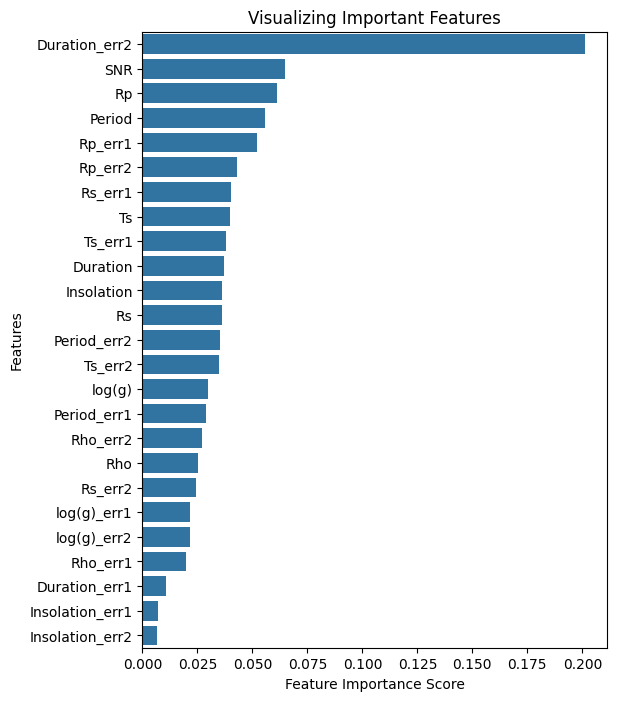

In [430]:
'''
y_pred = clf.predict(X_test)
print(" Accuracy: {:.3f}%".format(get_accuracy(*get_classifications(y_test, y_pred)) * 100))

y_pred = clf.predict(X_test)
print(" Sensitivity: {:.3f}%".format(get_sensitivity(*get_classifications(y_test, y_pred)) * 100))

y_pred = clf.predict(X_test)
print(" Specificity: {:.3f}%".format(get_specificity(*get_classifications(y_test, y_pred)) * 100))

y_pred = clf.predict(X_test)
print(" Precision: {:.3f}%".format(get_precision(*get_classifications(y_test, y_pred)) * 100))

y_pred = clf.predict(X_test)
print(" F1 Score: {:.5f}".format(get_f1_score(*get_classifications(y_test, y_pred))))

y_pred = clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Real Values');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
#plt.savefig('my_plot.JPEG')
plt.show()
'''
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
plt.figure(figsize = (6, 8))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [431]:
x.columns

Index(['Period', 'Period_err1', 'Period_err2', 'Duration', 'Duration_err1',
       'Duration_err2', 'Rho', 'Rho_err1', 'Rho_err2', 'Rp', 'Rp_err1',
       'Rp_err2', 'Insolation', 'Insolation_err1', 'Insolation_err2', 'SNR',
       'Ts', 'Ts_err1', 'Ts_err2', 'log(g)', 'log(g)_err1', 'log(g)_err2',
       'Rs', 'Rs_err1', 'Rs_err2'],
      dtype='object')

In [580]:
# load model later
model = joblib.load("rf_model.pkl")
#scale = joblib.load('scaler.pkl')
# use it for predictions
a = pd.read_csv('fin.csv', index_col = False)
a = a.drop('ID', axis = 1)
X_test = pd.DataFrame(scale.transform(a), index=a.index, columns=a.columns)
y_pred = loaded_model.predict(X_test)

In [597]:
def run_model(X_scaled, user_id_column=None):
        
    # Handle error case from preprocessing
    if X_scaled is None:
        return {"error": "Failed to preprocess the CSV file"}
    
    # Handle preprocessing error
    if isinstance(X_scaled, str):  # Error message returned
        return {"error": X_scaled}

    if model is not None and hasattr(model, 'predict'):
        # Use pre-trained model for predictions
        clf = model
        print("✅ Using pre-trained model for predictions")

        start_time = time.time()
        y_pred = clf.predict(X_scaled)
        y_pred_proba = clf.predict_proba(X_scaled)
        elapsed_time = time.time() - start_time

        print(f"Y_pred: {y_pred[550:560]}")
        # y pred correct here
        # Create predictions with ID (if available) or row index
        predictions = []
        for i in range(len(y_pred)):
            pred_dict = {'prediction': y_pred[i],
                'confidence': float(max(y_pred_proba[i])),
                'prediction_label': 'CANDIDATE' if y_pred[i] == 1 else 'CONFIRMED'} 
            predictions.append(pred_dict)
        
        print(f"Predictions slice [550:560]: {predictions[550:560]}")
        results = {
            "predictions": predictions,
            "total_samples": len(predictions),
            "candidate_count": sum(1 for p in y_pred if p == 1),
            "confirmed_count": sum(1 for p in y_pred if p == 0),
            "runtime_seconds": round(elapsed_time, 2),
        
            "model_info": {
                "model_type": "Random Forest",
                "pre_trained": True
            }
        }
        #print(f"Results: {results}")
    else:
        # If no pre-trained model is available
        return {"error": "No pre-trained model available. Please ensure rf_model.pkl and scaler.pkl files are present."}
    print(len(np.where(y_pred == 1)[0]))
    print(len(np.where(y_pred == 0)[0]))
    return results, y_pred

In [598]:
q, _ = run_model(X_test, user_id_column=None)

✅ Using pre-trained model for predictions
Y_pred: [0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
Predictions slice [550:560]: [{'prediction': np.float64(0.0), 'confidence': 0.979375, 'prediction_label': 'CONFIRMED'}, {'prediction': np.float64(1.0), 'confidence': 0.96625, 'prediction_label': 'CANDIDATE'}, {'prediction': np.float64(1.0), 'confidence': 0.99875, 'prediction_label': 'CANDIDATE'}, {'prediction': np.float64(0.0), 'confidence': 0.97625, 'prediction_label': 'CONFIRMED'}, {'prediction': np.float64(0.0), 'confidence': 0.989375, 'prediction_label': 'CONFIRMED'}, {'prediction': np.float64(0.0), 'confidence': 0.988125, 'prediction_label': 'CONFIRMED'}, {'prediction': np.float64(1.0), 'confidence': 0.7275, 'prediction_label': 'CANDIDATE'}, {'prediction': np.float64(0.0), 'confidence': 0.986875, 'prediction_label': 'CONFIRMED'}, {'prediction': np.float64(0.0), 'confidence': 0.968125, 'prediction_label': 'CONFIRMED'}, {'prediction': np.float64(0.0), 'confidence': 0.973125, 'prediction_label': 'CONFIR

In [631]:
np.where(_==0)[0]

array([    0,     1,     3, ..., 14351, 14353, 14354], shape=(6330,))